In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import joblib

from data_preprocessing import pipeline, filter_unnecessary_columns
from feature_preprocessing import pipeline2

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

### 데이터 전처리

In [2]:
# 로우 데이터 불러오기
file_path = "./storage/raw_data/병합_청약매물_목록_정보_픽스2.csv"
df = pd.read_csv(file_path)
df2 = pd.read_csv("./storage/raw_data/기준금리표.csv")

# 데이터 전처리
preprocessing_pipeline = pipeline(type='train')
df = preprocessing_pipeline.transform(df)

# 년도와 월만 남기기
df['모집공고일2'] = df['모집공고일'].str[:7]

df = df.merge(df2, left_on='모집공고일2', right_on='변경일자', how='left').drop(columns=['변경일자', '모집공고일2'])

# 학습할 모델별로 드랍할 칼럼 정의
# - 최고당첨가점: 공급지역코드, 거래금액(만원), 공급세대수
# 최저당첨가점: 공급지역코드, 거래금액(만원), 공급세대수
# 시세차익: 공급지역코드, 공급세대수

#  -----------------------------최고, 최저당점가점용-----------------------------------
df['시세차익'] = df['전용면적'] * df['전용면적당 시세차익']
df.drop(columns=['전용면적', '전용면적당 시세차익', '공급금액(최고가 기준)'], inplace=True)
# 최고, 최저당점가점용
df.drop(['공급지역코드', '거래금액(만원)', '공급세대수', '모집공고일'], axis=1, inplace=True)


# #  -----------------------------시세차익용-----------------------------------
# df['시세차익'] = df['전용면적'] * df['전용면적당 시세차익']
# df.drop(columns=['전용면적', '전용면적당 시세차익', '공급금액(최고가 기준)'], inplace=True)
# df.drop(['공급지역코드', '공급세대수', '모집공고일'], axis=1, inplace=True)


# 파일 저장
file_version = "250321-최저-금리추가"
output_file = f"./storage/train_data/train-{file_version}.csv"
df.to_csv(output_file, index=False, encoding='cp949')

/var/folders/pl/c9208lms3f937xrsflvwrm640000gn/T/ipykernel_57363/2954080847.py:3: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/Users/apple/developments/hk-project/src/data_preprocessing.py:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["최고당첨가점"].fillna(0, inplace=True)
/Users/apple/developments/hk-project/src/data_preprocessing.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

In [3]:
topic_labels = {
    "토픽 1": "토픽1\n(분양가와 대출 조건)",
    "토픽 2": "토픽2\n(청약 경쟁률 및 순위)",
    "토픽 3": "토픽3\n(아파트 타입 및 조건)",
    "토픽 4": "토픽4\n(당첨 가점 및 로또 청약)",
    "토픽 5": "토픽5\n(부동산 시장)",
    "토픽 6": "토픽6\n(신도시 개발 및 인프라 조성)",
    "토픽 7": "토픽7\n(청약 접수 및 아파트 면적)",
}

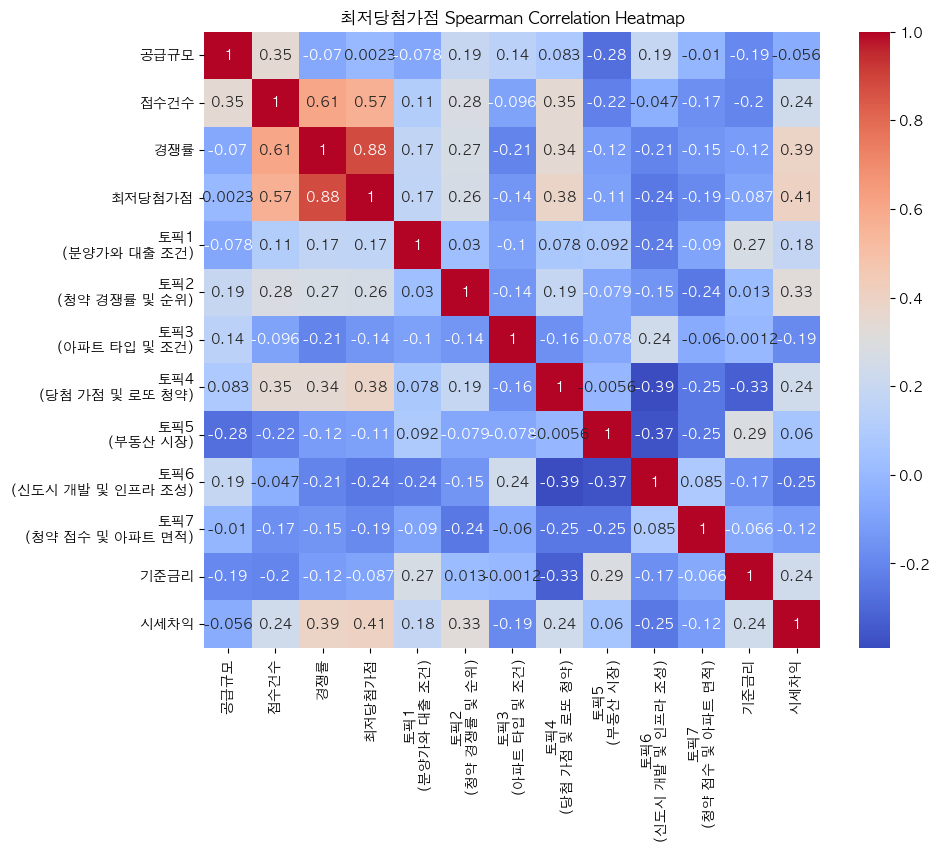

In [4]:
import seaborn as sns

numeric_df = df.select_dtypes(include=[np.number])

numeric_df.rename(columns=topic_labels, inplace=True)

corr_matrix = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('최저당첨가점 Spearman Correlation Heatmap')
plt.show()


### 모델 학습 및 평가

In [5]:
# 전처리된 데이터 가져오기
file_version = "250321-최저-금리추가"
file_path = f"./storage/train_data/train-{file_version}.csv"
df = pd.read_csv(file_path, encoding='cp949')

In [6]:
X = df.drop(columns=["최저당첨가점"])
Y = df["최저당첨가점"]

X_train, X_test, y_train, y_test = train_test_split(
    X,  # 타겟
    Y,  
    test_size=0.2,
    random_state=42
)

In [7]:
feature_pipeline = pipeline2()

# 학습 데이터(X_train)에 fit
feature_pipeline.fit(X_train)

# 학습 데이터(X_train)를 변환
X_train_transformed = feature_pipeline.transform(X_train)

# 테스트 데이터(X_test)를 변환
X_test_transformed = feature_pipeline.transform(X_test)

/opt/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [7]:
# shap test data 저장

X_test_transformed.to_csv('./storage/shap_test_data/low_lgb_X_test_transformed.csv', index=False)

In [8]:
# 피쳐 파이프라인 저장 

version = 'low_lgb_0.0.1'
joblib.dump(feature_pipeline, f"./storage/trained_pipeline/pipeline_{version}.pkl")

['./storage/trained_pipeline/pipeline_low_lgb_0.0.1.pkl']

# 여기까지는 고정적 트레인 사용

### 학습

### RF

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 랜덤 포레스트 회귀 모델 생성
rf_model = RandomForestRegressor()

# 하이퍼파라미터 범위 설정
rf_param_grid = {
    'n_estimators': np.arange(800, 1100, 100), 
    'max_depth': np.arange(10, 60, 10), 
    'max_features': np.arange(6, 17, 2),  
    'min_samples_leaf': np.arange(8, 19, 2),  
    'min_samples_split': np.arange(8, 21, 2) 
}

# 랜덤 서치 설정
rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=rf_param_grid, 
    cv=5, 
    n_iter=100
)

# 모델 학습
rf_random_search.fit(X_train_transformed, y_train)

# 베스트 파라미터 출력
print("베스트 파라미터:")
print(rf_random_search.best_params_)

# 테스트 데이터에서 예측 수행
y_pred = rf_random_search.best_estimator_.predict(X_test_transformed)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R² 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"랜덤 포레스트 - RMSE: {rmse:.4f}, R²: {r2:.4f}")


베스트 파라미터:
{'n_estimators': np.int64(800), 'min_samples_split': np.int64(14), 'min_samples_leaf': np.int64(8), 'max_features': np.int64(16), 'max_depth': np.int64(20)}
랜덤 포레스트 - RMSE: 6.1712, R²: 0.8129


Random Forest - RMSE: 7.4695011398105, R^2: 0.8902149384852229


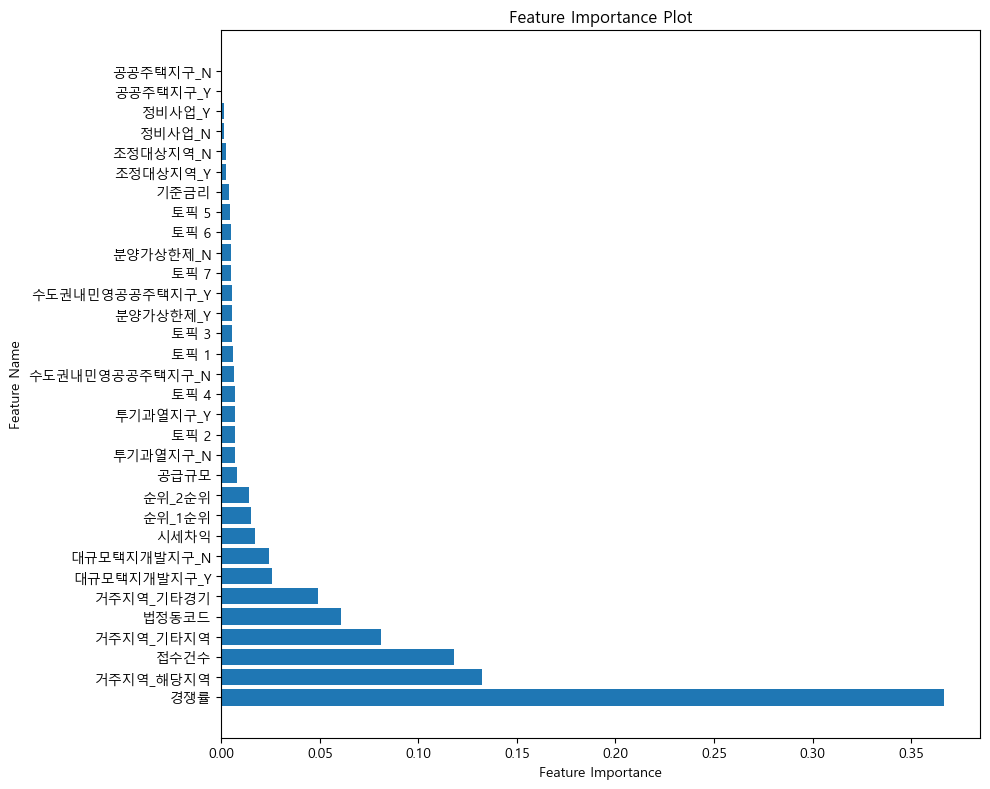

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# 랜덤 포레스트 회귀 모델 생성 및 학습
rf_model = RandomForestRegressor(
    max_depth=20, 
    max_features=16, 
    min_samples_leaf=8,
    min_samples_split=14, 
    n_estimators=800
)

rf_model.fit(X_train_transformed, y_train)

y_pred_rf = rf_model.predict(X_test_transformed)

# RMSE와 R^2 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf}, R^2: {r2_rf}")

# Feature Importance 평균 계산 및 출력
# 랜덤 포레스트 모델의 feature_importances_ 속성을 사용
feature_importances = rf_model.feature_importances_

# Feature Importance 시각화
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(X_train_transformed.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Plot")
plt.tight_layout()  # 레이아웃 조정
plt.show()

### XGBoost

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor()

xgb_param_grid = {
    'max_depth': np.arange(3, 9),  
    'min_child_weight': np.arange(1, 5),  
    'subsample': np.linspace(0.5, 1.0, 6),  # subsample의 범위를 0.5에서 1.0 사이로 설정
    'eta': np.logspace(-4, -1, 10),  
    'n_estimators': np.arange(50, 200, 50)  
}

# 랜덤 서치 설정
xgb_random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=xgb_param_grid, 
    cv=5, 
    n_iter=50
)

# 모델 학습
xgb_random_search.fit(X_train_transformed, y_train)

# 베스트 파라미터 출력
print("베스트 파라미터:")
print(xgb_random_search.best_params_)

# 테스트 데이터에서 예측 수행
y_pred = xgb_random_search.best_estimator_.predict(X_test_transformed)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R² 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"XGBoost - RMSE: {rmse:.4f}, R²: {r2:.4f}")


베스트 파라미터:
{'subsample': np.float64(0.5), 'n_estimators': np.int64(100), 'min_child_weight': np.int64(1), 'max_depth': np.int64(7), 'eta': np.float64(0.1)}
XGBoost - RMSE: 5.8896, R²: 0.8296


XGBoost - RMSE: 7.257624525518695, R^2: 0.8963548352763009


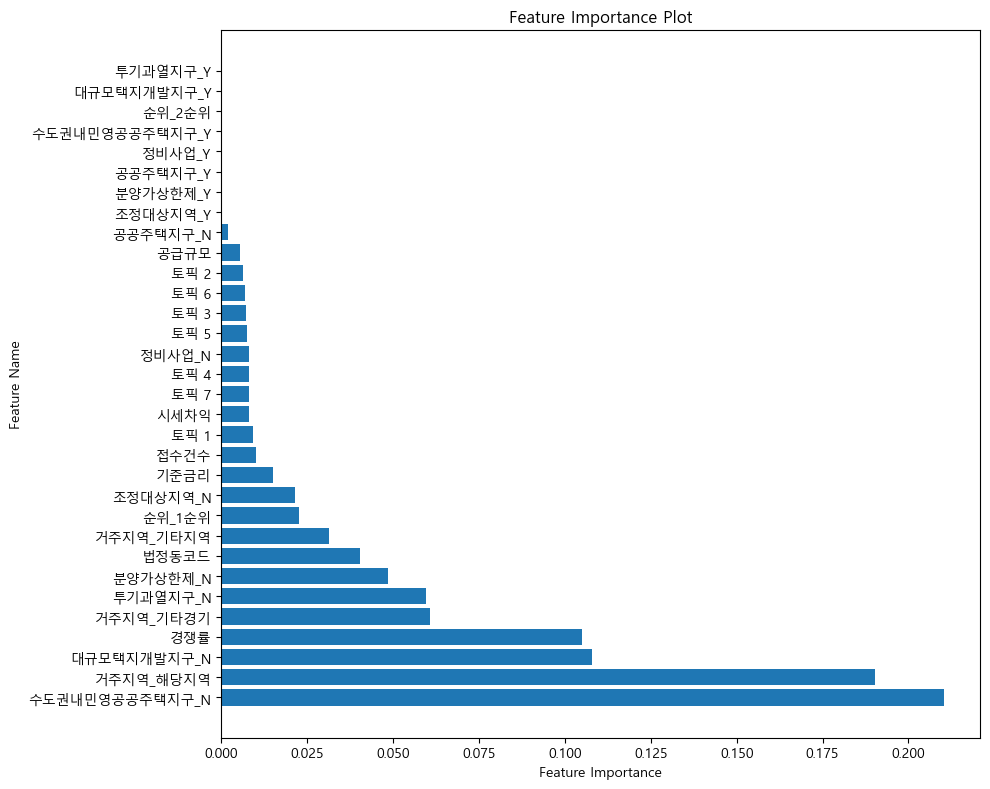

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBRegressor(
    max_depth=7, 
    min_child_weight=1, 
    subsample=0.5, 
    eta=0.1, 
    n_estimators=100
)

xgb_model.fit(X_train_transformed, y_train)

y_pred_xgb = xgb_model.predict(X_test_transformed)

# RMSE와 R^2 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb}, R^2: {r2_xgb}")

# Feature Importance 평균 계산 및 출력
# XGBoost 모델의 feature_importances_ 속성을 사용
feature_importances = xgb_model.feature_importances_

# Feature Importance 시각화
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(X_train_transformed.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance Plot")
plt.tight_layout()  # 레이아웃 조정
plt.show()


### LGB

In [8]:
topic_labels = {
    "토픽 1": "토픽1 (분양가와 대출 조건)",
    "토픽 2": "토픽2 (청약 경쟁률 및 순위)",
    "토픽 3": "토픽3 (아파트 타입 및 조건)",
    "토픽 4": "토픽4 (당첨 가점 및 로또 청약)",
    "토픽 5": "토픽5 (부동산 시장)",
    "토픽 6": "토픽6 (신도시 개발 및 인프라 조성)",
    "토픽 7": "토픽7 (청약 접수 및 아파트 면적)",
}

In [10]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import warnings

# 워닝 무시 설정
warnings.filterwarnings("ignore", category=UserWarning)

# LightGBM 모델 생성
lgb_model = lgb.LGBMRegressor(verbosity=-1)

# 하이퍼파라미터 범위 설정
lgb_param_grid = {
    'max_depth': np.arange(3, 9),  
    'num_leaves': np.arange(31, 127),  
    'min_data_in_leaf': np.arange(10, 50),  
    'subsample': np.linspace(0.5, 1.0, 6),  
    'colsample_bytree': np.linspace(0.5, 1.0, 6),  
    'learning_rate': np.logspace(-4, -1, 10),  
    'n_estimators': np.arange(50, 200, 50)  
}

# 랜덤 서치 설정
lgb_random_search = RandomizedSearchCV(
    lgb_model, 
    param_distributions=lgb_param_grid, 
    cv=5, 
    n_iter=100,
)

# 모델 학습
lgb_random_search.fit(X_train_transformed, y_train)

# 베스트 파라미터 출력
print("베스트 파라미터:")
print(lgb_random_search.best_params_)

# 테스트 데이터에서 예측 수행
y_pred = lgb_random_search.best_estimator_.predict(X_test_transformed)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R² 계산
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"LightGBM - RMSE: {rmse:.4f}, R²: {r2:.4f}")


베스트 파라미터:
{'subsample': np.float64(0.6), 'num_leaves': np.int64(96), 'n_estimators': np.int64(150), 'min_data_in_leaf': np.int64(30), 'max_depth': np.int64(8), 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(1.0)}
LightGBM - RMSE: 5.8678, R²: 0.8309


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 29
[LightGBM] [Info] Start training from score 49.488606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

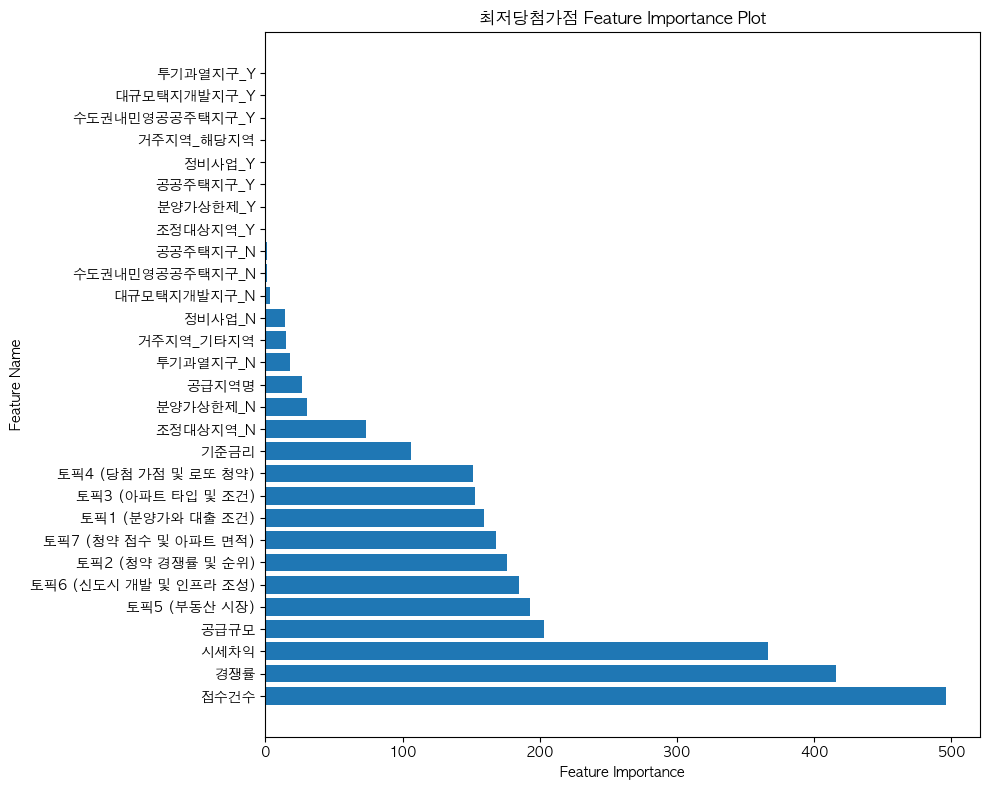

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

# LightGBM 모델 생성 및 학습
lgb_model = lgb.LGBMRegressor(
    max_depth=8, 
    num_leaves=96, 
    min_data_in_leaf=30, 
    subsample=0.6, 
    colsample_bytree=1.0, 
    learning_rate=0.1, 
    n_estimators=150
)

lgb_model.fit(X_train_transformed, y_train)

# 이후에 rename 수행 (그래프용)
X_train_transformed.rename(columns=topic_labels, inplace=True)
X_test_transformed.rename(columns=topic_labels, inplace=True)

y_pred_lgb = lgb_model.predict(X_test_transformed)

# RMSE와 R^2 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_lgb, r2_lgb = evaluate_model(y_test, y_pred_lgb)
print(f"LightGBM - RMSE: {rmse_lgb}, R^2: {r2_lgb}")

# Feature Importance 평균 계산 및 출력
# LightGBM 모델의 feature_importances_ 속성을 사용
feature_importances = lgb_model.feature_importances_

# Feature Importance 시각화
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(X_train_transformed.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("최저당첨가점 Feature Importance Plot")
plt.tight_layout()  # 레이아웃 조정
plt.show()


/opt/anaconda3/envs/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


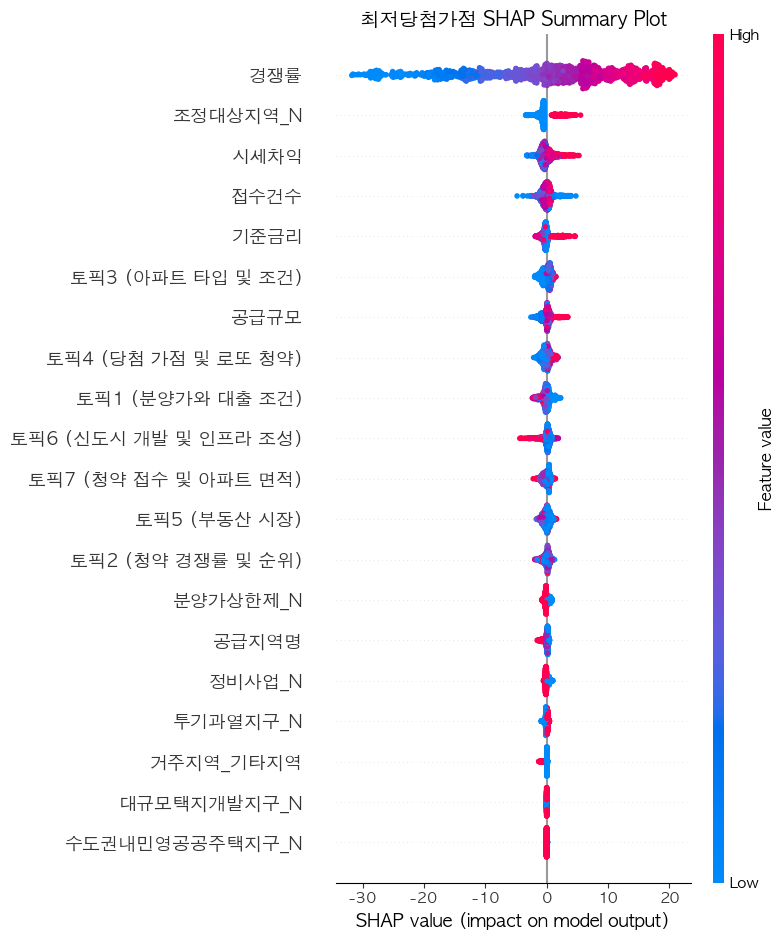

In [10]:
import shap
import matplotlib.pyplot as plt

# SHAP 값 계산
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_train_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train_transformed, show=False)  # 🔹 show=False: 자동 show 막음

# 🔽 타이틀 추가
plt.title("최저당첨가점 SHAP Summary Plot", fontsize=14)
plt.tight_layout()
plt.show()


### 모델 저장 

In [20]:
# 모델 저장 및 로드

version = 'low_lgb_0.0.1'

# 모델 저장
joblib.dump(lgb_model, f"./storage/trained_model/model_{version}.pkl")

['./storage/trained_model/model_low_lgb_0.0.1.pkl']

In [8]:
# 모델 로드
loaded_model = joblib.load("./storage/trained_model/model_0.0.1.pkl")

# 예측
# X_test = np.array([[1, 2]])
# prediction = loaded_model.predict(X_test)
# print("Prediction:", prediction)